# <a id='toc1_'></a>[__Работа с текстовыми данными__](#toc0_)

**Содержание**<a id='toc0_'></a>    
- [__Работа с текстовыми данными__](#toc1_)    
  - [__Импорты и настройки__](#toc1_1_)    
  - [__Загрузка и очистка данных__](#toc1_2_)    
  - [__Векторизация__](#toc1_3_)    
  - [__TF-IDF: Term Frequency–Inverse Document Frequency__](#toc1_4_)    
  - [__Стемминг__](#toc1_5_)    
  - [__Лемматизация__](#toc1_6_)    
  - [__Классификация__](#toc1_7_)    
  - [__Важность признаков__](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Импорты и настройки__](#toc0_)

In [1]:
# стандартная библиотека
from bz2 import BZ2File
import json
import re

In [2]:
# сторонние библиотеки
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
import nltk
import matplotlib
import numpy as np
import seaborn as sns

In [3]:
# глобальные настройки графических библиотек
params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(palette='tab10', style='ticks', rc=params)
matplotlib.rcParams['figure.dpi'] = 400

***
## <a id='toc1_2_'></a>[__Загрузка и очистка данных__](#toc0_)

Модели машинного обучения, как правило, действуют в предположении, что матрица "объект-признак" вещественнозначная, поэтому при работе с текстами для каждого из них необходимо составить его признаковое описание. Для этого широко используются техники векторизации, TF-IDF и пр. Рассмотрим их на примере [__датасета__](https://disk.yandex.com/d/tYXzmtPhT-s3zQ) отзывов о банках.

[__tqdm__](https://tqdm.github.io/)

In [4]:
responses = []

with BZ2File('banki_responses.json.bz2') as f:
    for row in tqdm(f):
        response = json.loads(row)
        if not response['rating_not_checked']:
            responses.append(response)
            
responses[0]

201030it [01:30, 2230.57it/s]


{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

In [5]:
f = lambda resp: resp['text'].__contains__('отвратительно')
disgust = filter(f, responses)
pprint(next(disgust)['text'])

('Банк отказывается возвращать депозит после окончания срока действия '
 'договора. Предлагает обращаться в ЦО, где в порядке живой очереди можно '
 'забирать не более 500$/день в порядке живой очереди. Налицо отвратительное '
 'отношение к вкладчикам. Советую всем обращаться\xa0с жалобой в ЦБ и '
 'роспотребнадзор.')


In [6]:
def cleanup(text):
    return re.sub(r'[^а-яё]+', ' ', text.lower())

In [7]:
ratings, texts = [], []

for resp in responses:
    if (rating := resp['rating_grade']) is not None:
        ratings.append(rating)
        texts.append(cleanup(resp['text']))

<Axes: ylabel='Count'>

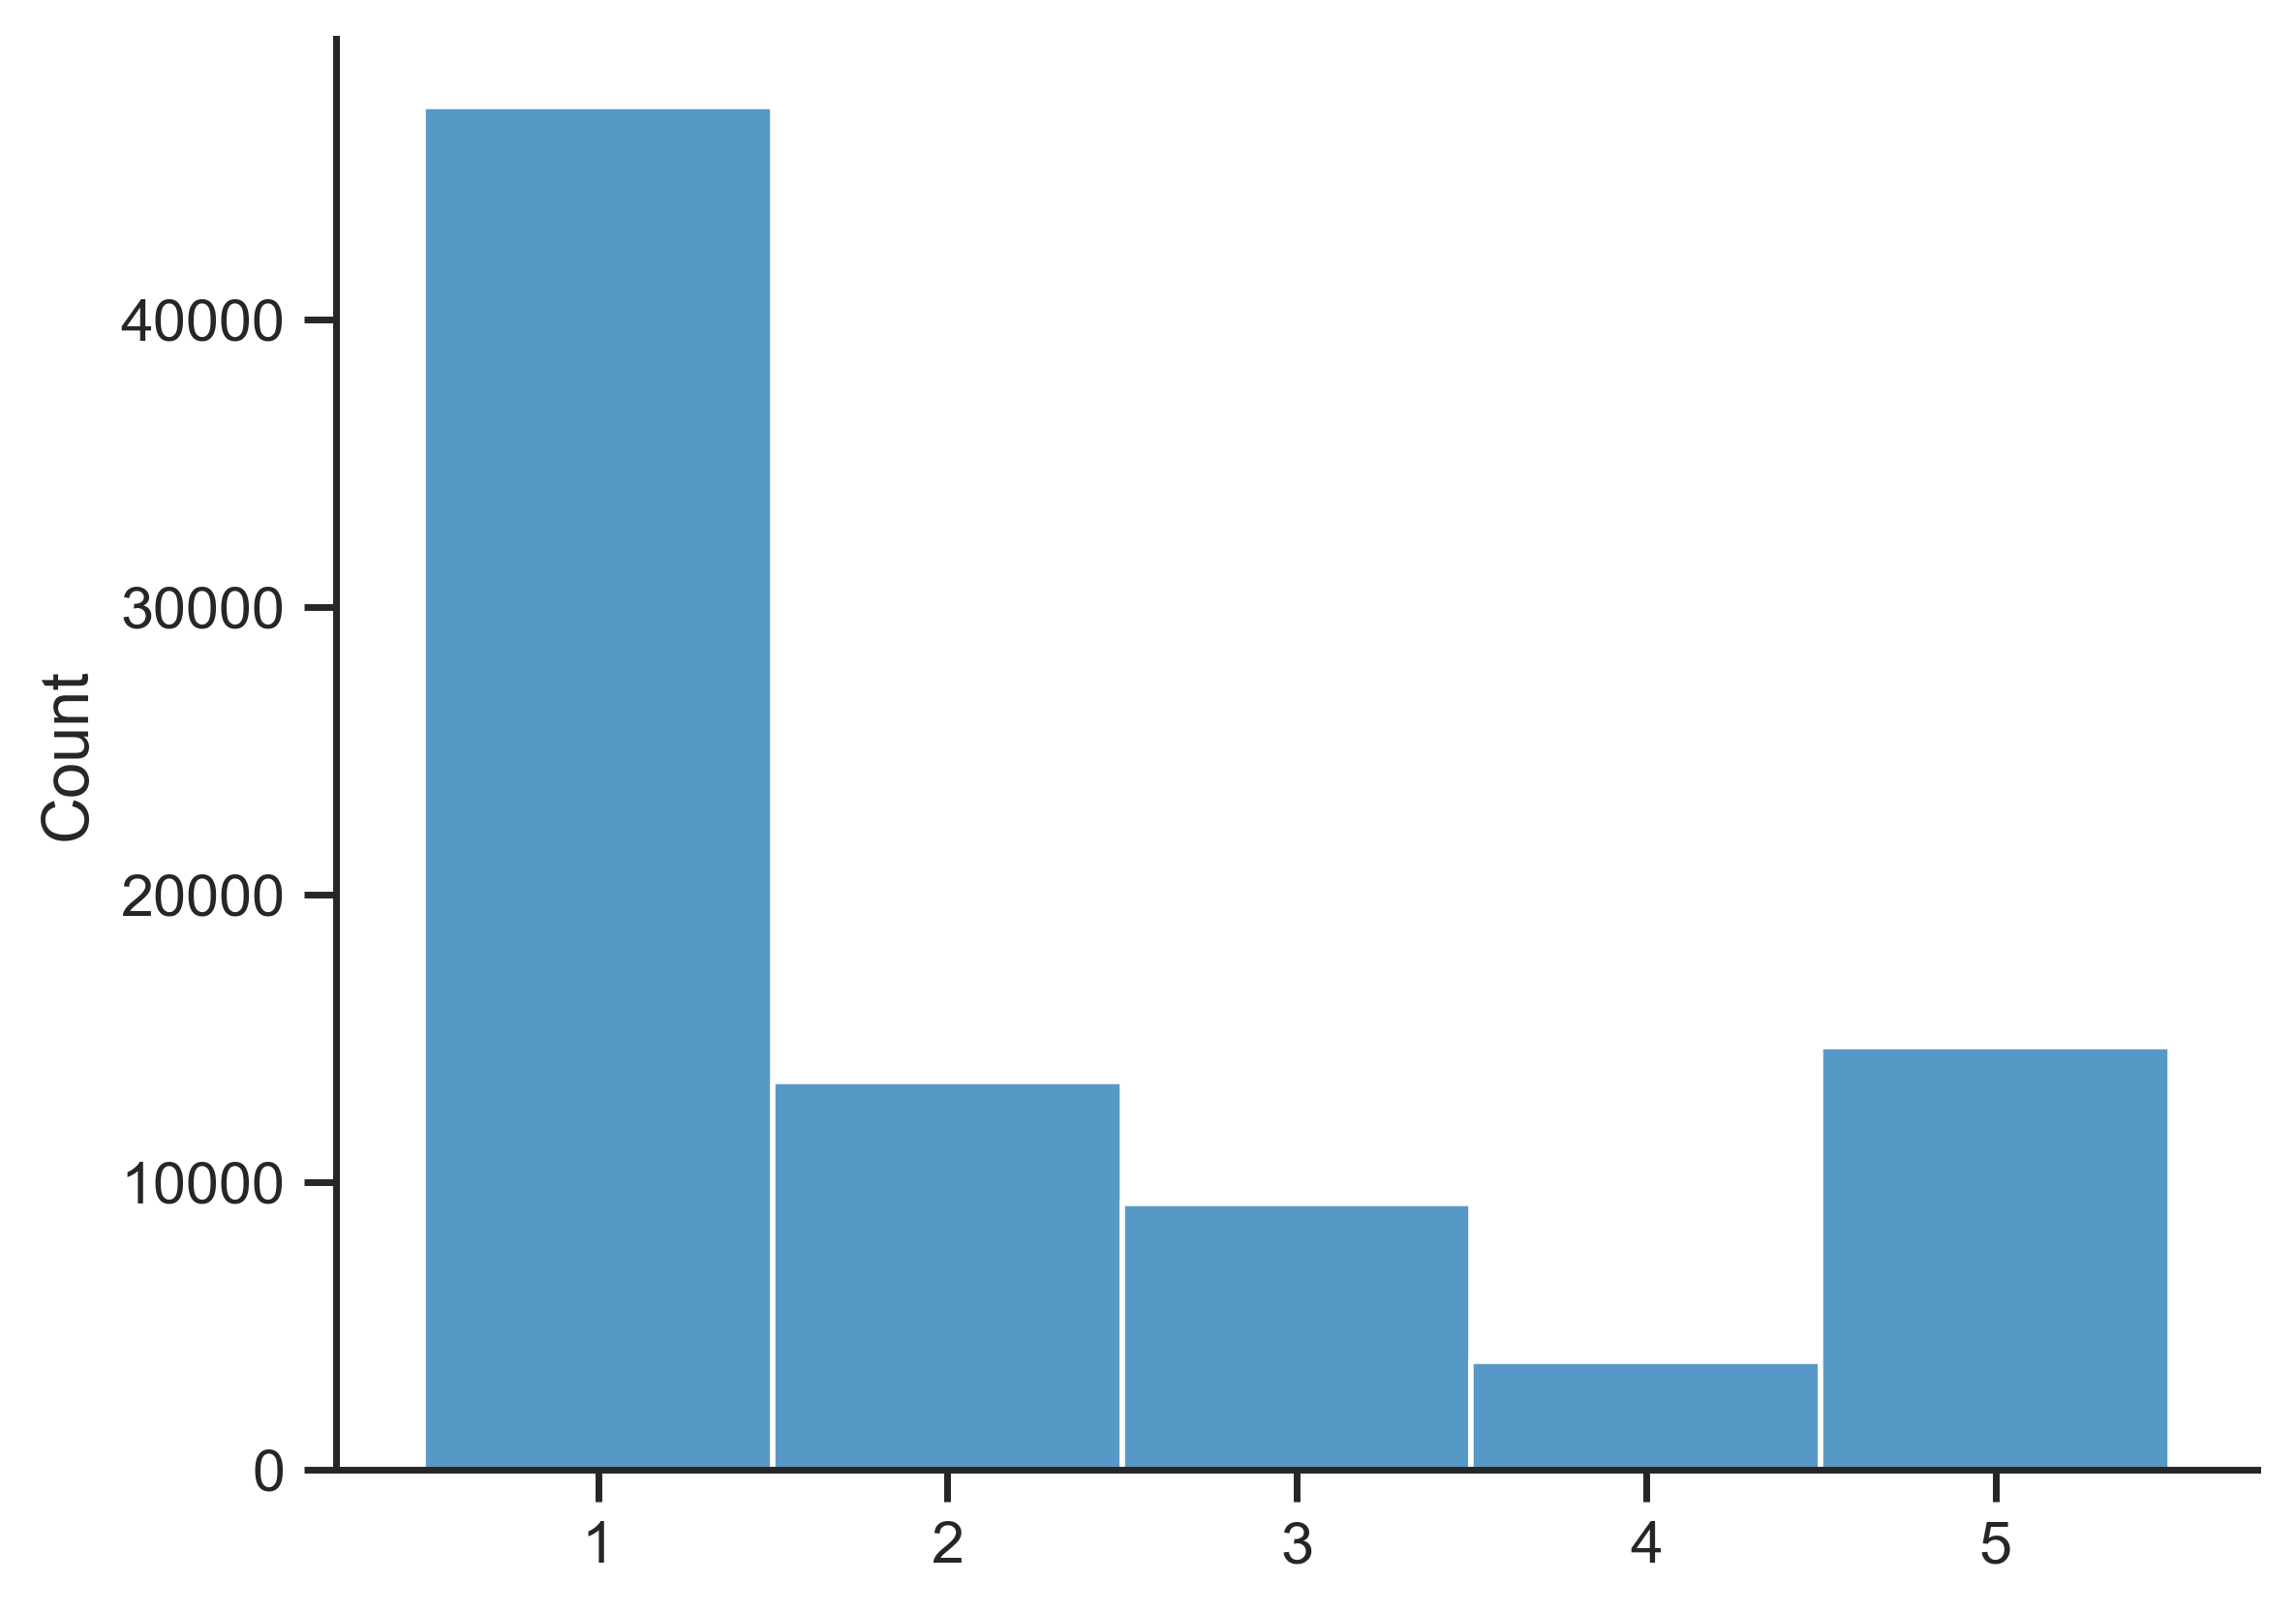

In [8]:
sns.histplot(ratings, discrete=True)

***
## <a id='toc1_3_'></a>[__Векторизация__](#toc0_)

Самый очевидный способ формирования признакового описания текстов - __векторизация__. Пусть имеется коллекция текстов $D = \{d_i\}_{i=1}^l$ и словарь всех слов, встречающихся в выборке $V = \{v_j\}_{j=1}^d.$ Тогда некоторый текст $d_i$ описывается вектором $(x_{ij})_{j=1}^d,$ где
$$x_{ij} = \sum_{v \in d_i} [v = v_j].$$

__Таким образом, текст $d_i$ описывается вектором количества вхождений каждого слова из словаря в данный текст__.

[__sklearn.feature_extraction.text.CountVectorizer__](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn-feature-extraction-text-countvectorizer)

In [9]:
vectorizer = CountVectorizer(encoding='utf8', min_df=5)
vectorizer.fit(texts)
vectorizer.transform([texts[0]])

<1x72478 sparse matrix of type '<class 'numpy.int64'>'
	with 166 stored elements in Compressed Sparse Row format>

***
## <a id='toc1_4_'></a>[__TF-IDF: Term Frequency–Inverse Document Frequency__](#toc0_)

Ещё один способ работы с текстовыми данными - [__TF-IDF__](https://en.wikipedia.org/wiki/Tf–idf) (_Term Frequency–Inverse Document Frequency_). Рассмотрим коллекцию текстов $D$. Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. _Term Frequency_ – количество вхождений слова в текст в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ - количество вхождений слова $t$ в текст $d$.

2. _Inverse Document Frequency_
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D)$.

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.

[__sklearn.feature_extraction.text.TfidfVectorizer__](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn-feature-extraction-text-tfidfvectorizer)

In [10]:
vectorizer = TfidfVectorizer(encoding='utf8', min_df=5)
vectorizer.fit(texts)
vectorizer.transform([texts[0]])

<1x72478 sparse matrix of type '<class 'numpy.float64'>'
	with 166 stored elements in Compressed Sparse Row format>

Заметим, что оба метода возвращают вектор длины 72478 (размер словаря).

***
## <a id='toc1_5_'></a>[__Стемминг__](#toc0_)

Одно и то же слово может встречаться в различных формах (например, "сотрудник" и "сотрудника"), но описанные выше методы интерпретируют их как различные слова, что делает признаковое описание избыточным. Устранить эту проблему можно при помощи __лемматизации__ и __стемминга__.

[__Stemming__](https://en.wikipedia.org/wiki/Stemming) -  это нахождение основы слова. В результате применения данной процедуры однокоренные слова, как правило, преобразуются к одинаковому виду.

Примеры стемминга:

| Word        | Stem           |
| ----------- |:-------------:|
| вагон | вагон |
| вагона | вагон |
| вагоне | вагон |
| вагонов | вагон |
| вагоном | вагон |
| вагоны | вагон |
| важная | важн |
| важнее | важн |
| важнейшие | важн |
| важнейшими | важн |
| важничал | важнича |
| важно | важн |

[__Snowball__](http://snowball.tartarus.org/) - фреймворк для написания алгоритмов стемминга. Алгоритмы стемминга отличаются для разных языков и используют знания о конкретном языке - списки окончаний для разных частей речи, разных склонений и т.д. Пример алгоритма для русского языка - [__Russian stemming__](http://snowballstem.org/algorithms/russian/stemmer.html).

In [11]:
def stemText(text, stemmer):
    tokens = text.split()
    return ' '.join(map(lambda t: stemmer.stem(t), tokens))

In [12]:
stemmer = nltk.stem.snowball.RussianStemmer()
stemmed_texts = [stemText(text, stemmer) for text in tqdm(texts)]

100%|██████████| 88658/88658 [14:30<00:00, 101.81it/s]


***
## <a id='toc1_6_'></a>[__Лемматизация__](#toc0_)

[__Лемматизация__](https://en.wikipedia.org/wiki/Lemmatisation) - процесс приведения слова к его нормальной форме, _лемме_:
* для существительных - именительный падеж, единственное число;
* для прилагательных - именительный падеж, единственное число, мужской род;
* для глаголов, причастий, деепричастий - глагол в инфинитиве.

***
## <a id='toc1_7_'></a>[__Классификация__](#toc0_)

Воспользуемся TF-IDF для решения задачи классификации отзывов на образцы с положительной оценкой (4-5) и отзывы с отрицательной оценкой.

In [13]:
vectorizer = TfidfVectorizer(encoding='utf8', min_df=5)
X = vectorizer.fit_transform(stemmed_texts)
y = (np.array(ratings) > 3).astype(int)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [15]:
logreg = LogisticRegression(max_iter=10_000).fit(X_train, y_train)
accuracy_score(y_test, logreg.predict(X_test))

0.9428904428904429

In [16]:
roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])

0.9727978899233105

***
## <a id='toc1_8_'></a>[__Важность признаков__](#toc0_)

Веса признаков в линейной модели в случае, если признаки отмасштабированы, характеризуют степень их влияния на значение целевой переменной. В задаче классификации текстов, кроме того, признаки являются хорошо интерпретируемыми, поскольку каждый из них соответствует конкретному слову. Изучим влияние конкретных слов на значение целевой переменной.

In [17]:
features = vectorizer.get_feature_names_out()
features = features[np.argsort(logreg.coef_[0])]

Тянут в положительный класс:

In [18]:
features[-30:]

array(['отзыв', 'сраз', 'все', 'нрав', 'выраз', 'отмет', 'оценк', 'очен',
       'пятерк', 'помогл', 'грамотн', 'порадова', 'доброжелательн',
       'пробл', 'четк', 'всегд', 'понрав', 'благодар', 'отличн', 'удобн',
       'молодц', 'вежлив', 'положительн', 'поблагодар', 'довол', 'быстр',
       'оперативн', 'благодарн', 'приятн', 'спасиб'], dtype=object)

Тянут в отрицательный класс:

In [19]:
features[:30]

array(['ответ', 'не', 'зач', 'вы', 'эт', 'поч', 'ваш', 'час', 'отказа',
       'невозможн', 'завтр', 'ладн', 'нельз', 'видим', 'медлен',
       'нейтральн', 'нет', 'потеря', 'никт', 'ужасн', 'сегодн', 'клиент',
       'отвратительн', 'выясн', 'говор', 'могут', 'некомпетентн', 'пыта',
       'опя', 'долж'], dtype=object)

***